In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import os
import random
import csv
from IPython.core.display import HTML
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average



def load_data(filePath):
    #loads csv file into data frame and returns the data frame
    df = pd.DataFrame.from_csv(filePath)
    #unindex GameId
    df = df.reset_index('GameId')
    return df



def preprocess_data(df):
    '''This function will apply preprocessing steps to the initial data frame'''
    
    #sort the data frame so all games are in order
    df = df.sort_values(by = ['GameId', 'Quarter', 'Minute', 'Second'], ascending = [True, True, False, False])
    
    #we only want plays that are RUSH or PASS for purposes of prediction
    df_subset = df[np.logical_or(df.PlayType == 'RUSH', df.PlayType == 'PASS')]
    
    #subset of the data that we believe will be important for our prediction problem
    df_final = df_subset[['OffenseTeam', 'DefenseTeam', 'Down', 'ToGo'
                      , 'YardLine', 'YardLineDirection', 'Quarter', 'Minute', 'Second','Formation', 'PlayType']]
    
    #get rid of rows that have NaN's in any columns
    df_final = df_final.dropna()
    
    #create a label encoding column in the dataframe for PlayType since it is the variable we are trying to predict
    df_final.PlayType = df_final.PlayType.astype('category')
    df_final['PlayType_cat'] = df_final.PlayType.cat.codes
    
    #create dummy variables for each feature that is categorical
    #(OffenseTeam, DefenseTeam, YardLineDirection, and Formation)
    df_final = pd.get_dummies(df_final, columns = ['OffenseTeam', 'DefenseTeam', 'YardLineDirection', 'Formation'])
    
    return df_final


def round_array(array):
    '''return a list of floats that have been rounded from given array'''
    lst_to_return = []
    for entry in array:
        lst_to_return.append(round(entry))
    return lst_to_return

In [3]:
filePath = 'C:\\Users\\abird\\Documents\\Springboard\\Capstone Project\\NFL\\pbp-2014.csv'
df = load_data(filePath)
df_final = preprocess_data(df)

*Let's create a training and testing set*

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df_final.drop(labels = ['PlayType', 'PlayType_cat'], axis = 1).values, 
                                              df_final.PlayType_cat.values, random_state = 69)

*Let's fit a logistic regression model to predict PlayType (run or pass)*

In [5]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
print 'Accuracy score on training set: ', accuracy_score(clf.predict(x_train), y_train)
print 'Accuracy score on test set: ', accuracy_score(clf.predict(x_test), y_test)

Accuracy score on training set:  0.722886997556
Accuracy score on test set:  0.737108190091


*Let's try 5-Fold Cross-Validation on the training set*

In [6]:
score = cv_score(clf, x_train, y_train)
print 'cv_score: ', score

cv_score:  0.722339098369


*Let's try Grid Search to find the best regularization constant for the logistic regression model*

In [7]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'C' : Cs }
model = GridSearchCV(LogisticRegression(), param_grid, scoring = 'accuracy', cv = 5)
model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='accuracy', verbose=0)

In [8]:
print 'The best regularization parameter from the Grid Search is:', model.best_params_['C']

The best regularization parameter from the Grid Search is: 1


In [9]:
model.grid_scores_

[mean: 0.70810, std: 0.00846, params: {'C': 0.001},
 mean: 0.72171, std: 0.00936, params: {'C': 0.1},
 mean: 0.72230, std: 0.00972, params: {'C': 1},
 mean: 0.72213, std: 0.00963, params: {'C': 10},
 mean: 0.72221, std: 0.00954, params: {'C': 100}]

In [10]:
print 'The accuracy score with the best regularization parameter is', accuracy_score(model.predict(x_test), y_test)

The accuracy score with the best regularization parameter is 0.737108190091


*Let's look at some other metrics for this model including the ROC Curve and AUC*

In [11]:
preds = model.predict_proba(x_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

y_test_rounded = round_array(y_test)
preds_rounded = round_array(preds)

#precision (true positives / [true positives + false positives])
precision = metrics.precision_score(y_test_rounded, preds_rounded)

#recall (true positives / [true positives + false negatives])
recall = metrics.recall_score(y_test_rounded, preds_rounded)

#F1 score is the geometric/harmonic mean of precision and recall; 2 * tp / ( 2 * tp + fp + fn)
f1_score = metrics.f1_score(y_test_rounded, preds_rounded)

df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
auc = metrics.auc(fpr, tpr)
print 'The precision score is', precision
print 'The recall score is', recall
print 'The F1 score is', f1_score
print 'The AUC for the ROC Curve is', auc

The precision score is 0.683569979716
The recall score is 0.638660770689
The F1 score is 0.660352710647
The AUC for the ROC Curve is 0.789088607116


*ROC Curve*

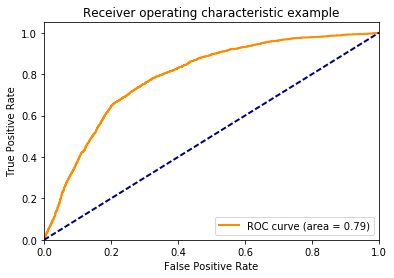

In [12]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC curve (area = %0.2f)' %auc)
plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()